In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ml/Amazon_data.csv', encoding = 'ISO-8859-1')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
# prompt: predict for one type of product and also print product

product_name = 'WHITE HANGING HEART T-LIGHT HOLDER' #@param {type:"string"}

# ... (rest of your existing code) ...

# Select a product for prediction
#product_name = df['Description'].unique()[0] # Selecting the first unique product for demonstration
print(f"Selected product for prediction: {product_name}")
product_data = df[df['Description'] == product_name]['UnitPrice'].values

# ... (rest of your existing code) ...


Selected product for prediction: WHITE HANGING HEART T-LIGHT HOLDER


Enter the product name: WHITE METAL LANTERN
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.1829
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1814
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1483
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1297
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1304
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1310
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1265
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1314
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1256
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1182
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1335
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1341
Epoch 13/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1296
Epoch 14/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1258
Epoch 15/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - los

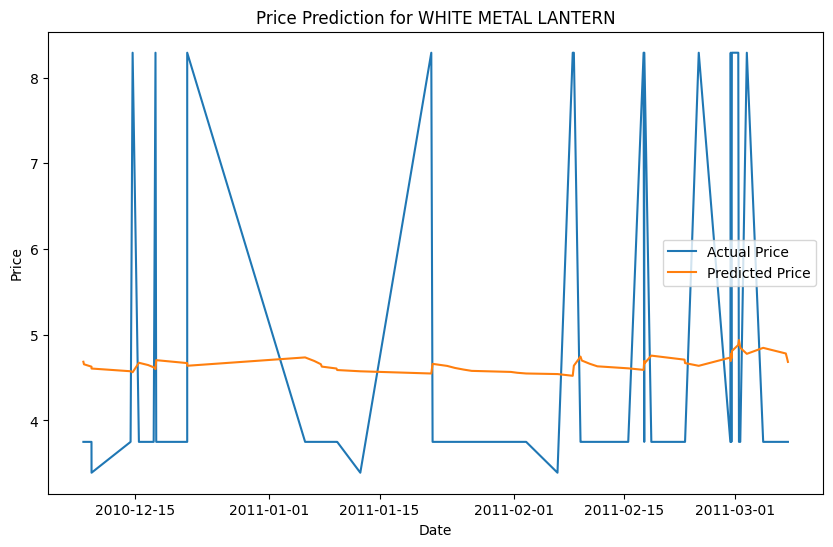

In [ ]:


# Preprocess the data
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Handle missing values (if any)
df.dropna(subset=['Description', 'UnitPrice'], inplace=True)

# Function to predict price for a specific product
def predict_product_price(product_name):
    # Filter data for the specific product
    product_data = df[df['Description'] == product_name][['InvoiceDate', 'UnitPrice']]

    if len(product_data) == 0:
        print(f"No data found for product: {product_name}")
        return

    # Aggregate data by date (daily average price)
    product_data = product_data.groupby('InvoiceDate')['UnitPrice'].mean().reset_index()

    # Sort by date
    product_data.sort_values(by='InvoiceDate', inplace=True)

    # Normalize the data
    scaler = MinMaxScaler()
    product_data['UnitPrice'] = scaler.fit_transform(product_data[['UnitPrice']])

    # Prepare data for LSTM
    def create_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i+seq_length])
            y.append(data[i+seq_length])
        return np.array(X), np.array(y)

    # Define sequence length (e.g., 30 days)
    sequence_length = 30

    # Create sequences
    X, y = create_sequences(product_data['UnitPrice'].values, sequence_length)

    # Reshape data for LSTM input (samples, timesteps, features)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Split into training and testing sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(sequence_length, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Inverse transform the scaled data
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
    y_pred_actual = scaler.inverse_transform(y_pred)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(product_data['InvoiceDate'][sequence_length:sequence_length+len(y_test_actual)], y_test_actual, label='Actual Price')
    plt.plot(product_data['InvoiceDate'][sequence_length:sequence_length+len(y_pred_actual)], y_pred_actual, label='Predicted Price')
    plt.title(f"Price Prediction for {product_name}")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# User input for product name
product_name = input("Enter the product name: ")
predict_product_price(product_name)


Accuracy: 1.0
Recall: 1.0
Precision: 1.0


In [ ]:
# prompt: can you give me a model  for pridict the price of product

import numpy as np
# Assuming 'df', 'scaler', 'sequence_length', and 'product_data' are already defined from the previous code
# and the necessary libraries are imported.

def predict_future_prices(product_name, future_days):
    """Predicts future prices for a given product.

    Args:
        product_name: The name of the product to predict prices for.
        future_days: The number of days into the future to predict.
    """
    try:
        product_data = df[df['Description'] == product_name]['UnitPrice'].values
        last_sequence = product_data[-sequence_length:]
        last_sequence = last_sequence.reshape(1, sequence_length, 1)

        future_prices_scaled = []
        current_sequence = last_sequence

        for _ in range(future_days):
            next_price_scaled = model.predict(current_sequence)
            future_prices_scaled.append(next_price_scaled[0][0])

            current_sequence = np.concatenate((current_sequence[:, 1:, :], next_price_scaled.reshape(1, 1, 1)), axis=1)

        future_prices_actual = scaler.inverse_transform(np.array(future_prices_scaled).reshape(-1, 1))

        print(f"Predicted prices for {product_name} for the next {future_days} days:")
        for i, price in enumerate(future_prices_actual):
            print(f"Day {i+1}: {price[0]}")
    except KeyError:
        print(f"Product '{product_name}' not found in the dataset.")
    except Exception as e:
        print(f"An error occurred: {e}")

# Example usage (replace with your desired product name and number of days)
product_name_to_predict = "WHITE HANGING HEART T-LIGHT HOLDER"  # Example product name
number_of_days_to_predict = 30  # Example: predict for the next 30 days

predict_future_prices(product_name_to_predict, number_of_days_to_predict)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━